In [1]:
import numpy as np
import pandas as pd

from pydantic import BaseModel, PydanticUserError
import scipy.integrate as integrate
from scipy.stats import cauchy
import matplotlib.pyplot as plt

In [2]:
class LiquidityProfile(BaseModel):
    """
    Generic model for concentrated liquidity global liquidity density function.
    
    Should require int_{-\infty}^{\infty} l(t)dt = C, where C is a global constant
    when no LPs add or remove funds from pool.

    Assumes continuous liquidity profile and input ticks are in "natural log" form
    such that price p = e ** (t), where t is the tick.
    """
    c: float

    def at(self, t: int) -> float:
        """
        `at` takes a tick value as input and returns the concentrated liquidity value
        in the pool.
        """
        raise PydanticUserError("Function not implemented.", code=None)

    def slip_y(self, t: int) -> float:
        """
        Tick slippage with respect to an infinitesimal amount of y.
        """
        return (2 / self.at(t)) * np.exp(-t/2)

    def slip_x(self, t: int) -> float:
        """
        Tick slippage with respect to an infinitesimal amount of x.
        """
        return - (2 / self.at(t)) * np.exp(t/2)

    def cost_y(self, i: int, f: int, rtol: float = 1e-4) -> float:
        """
        Amount of delta(y) in (+) or out (-) of pool to move pool tick
        from i -> f, assuming continuous liquidity profile.

        Raises if relative error is > rtol input.
        """
        def integrand(t: int):
            return (self.at(t) / 2) * np.exp(t/2)

        (v, er) = integrate.quad(integrand, i, f)
        if er > rtol:
            raise ValueError(f'relative error of {er} exceed rtol of {rtol}.')

        return v

    def cost_x(self, i: int, f: int, rtol: float = 1e-4) -> float:
        """
        Amount of delta(x) in (+) or out (-) of pool to move pool tick
        from i -> f, assuming continuous liquidity profile.

        Raises if relative error is > rtol input.
        """
        def integrand(t: int):
            return - (self.at(t) / 2) * np.exp(-t/2)

        (v, er) = integrate.quad(integrand, i, f)
        if er > rtol:
            raise ValueError(f'relative error of {er} exceed rtol of {rtol}.')

        return v

    def reserves_y(self, t: int, tmax: int, rtol: float = 1e-4) -> float:
        """
        Amount of y reserves housed in pool if at tick value of t.
        Effectively amount of y that can be taken out of pool (-),
        if swapped in infinite x.
        """
        if t < -tmax:
            raise ValueError("Tick max must be largest tick possible on discrete liquidity profile range of [-tmax, tmax].")

        return -self.cost_y(t, -tmax, rtol)

    def reserves_x(self, t: int, tmax: int, rtol: float = 1e-4) -> float:
        """
        Amount of x reserves housed in pool if at tick value of t.
        Effectively amount of x that can be taken out of pool (-),
        if swapped in infinite y.
        """
        if t > tmax:
            raise ValueError("Tick max must be largest tick possible on discrete liquidity profile range of [-tmax, tmax].")

        return -self.cost_x(t, tmax, rtol)

In [3]:
class CauchyLiquidityProfile(LiquidityProfile):
    """
    Cauchy distribution liquidity profile, with shape described by one scale parameter: gamma.

    l(t) = (c / (pi * gamma)) * (1 / (1 + (t / gamma) ** 2))
    """
    gamma: float

    def at(self, t: int) -> float:
        return self.c * cauchy.pdf(t, 0, self.gamma)

In [4]:
def from_bps_tick(tb: int) -> int:
    """
    Converts tick in bps form i.e. p = 1.0001 ** (tb)
    to tick in natural log form: p = e ** (t).
    """
    return np.log(1.0001) * tb

In [5]:
C = 10.0  # total liquidity parameter
GAMMA = 0.1  # scale parameter
MAX_TICK = 887272
TICK_SPACING = 10  # step size between ticks in arrays

In [6]:
clp = CauchyLiquidityProfile(c=C, gamma=GAMMA)

In [7]:
# should be c / (pi * gamma)
clp.at(0) == C / (np.pi * GAMMA)

True

In [8]:
# plot liquidity profile over ticks
bps_ticks = np.arange(start=-MAX_TICK, stop=MAX_TICK, step=TICK_SPACING)
log_ticks = from_bps_tick(bps_ticks)
liquidities = clp.at(log_ticks)

In [9]:
df = pd.DataFrame(data={'bps_ticks': bps_ticks, 'log_ticks': log_ticks, f'l(t) [c={C}, g={GAMMA}]': liquidities})
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]"
0,-887272,-88.722764,0.00004
1,-887262,-88.721764,0.00004
2,-887252,-88.720764,0.00004
3,-887242,-88.719764,0.00004
4,-887232,-88.718764,0.00004
...,...,...,...
177450,887228,88.718364,0.00004
177451,887238,88.719364,0.00004
177452,887248,88.720364,0.00004
177453,887258,88.721364,0.00004


<Axes: xlabel='bps_ticks'>

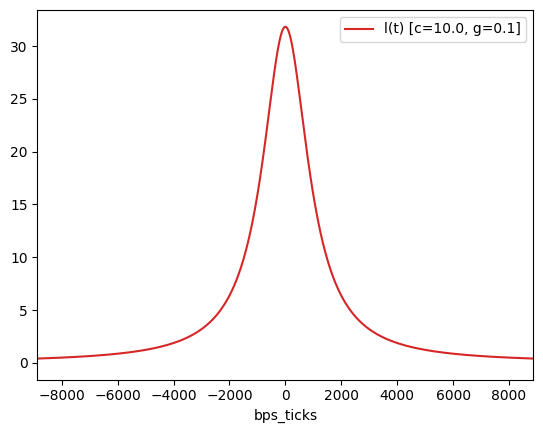

In [10]:
# plot +/- 60% 
df.plot(x='bps_ticks', y=f'l(t) [c={C}, g={GAMMA}]', xlim=(-MAX_TICK // 100, MAX_TICK // 100), color='C3')

In [11]:
# generate for more gammas
gammas = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.5, 1.0])

In [12]:
for g in gammas:
    df[f'l(t) [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).at(log_ticks)

In [13]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404


<Axes: xlabel='bps_ticks'>

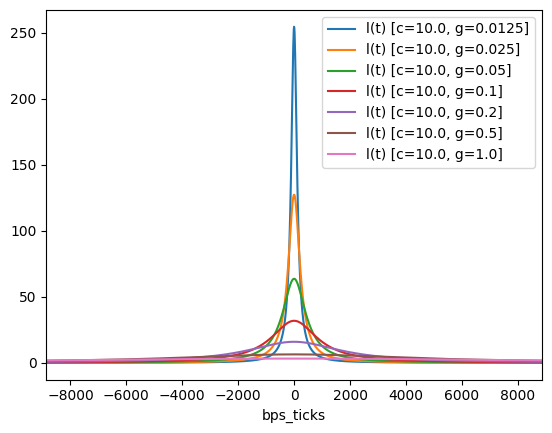

In [14]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

<Axes: xlabel='bps_ticks'>

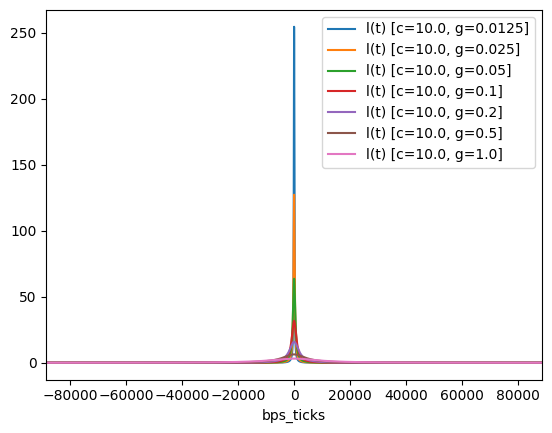

In [15]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 10, MAX_TICK // 10))

In [16]:
# generate for more global liquidity constant values
cs = np.array([1.0, 2.5, 5.0, 10.0, 20.0, 40.0])

In [17]:
for c in cs:
    df[f'l(t) [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).at(log_ticks)

In [18]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]","l(t) [c=2.5, g=0.1]","l(t) [c=5.0, g=0.1]","l(t) [c=20.0, g=0.1]","l(t) [c=40.0, g=0.1]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162


<Axes: xlabel='bps_ticks'>

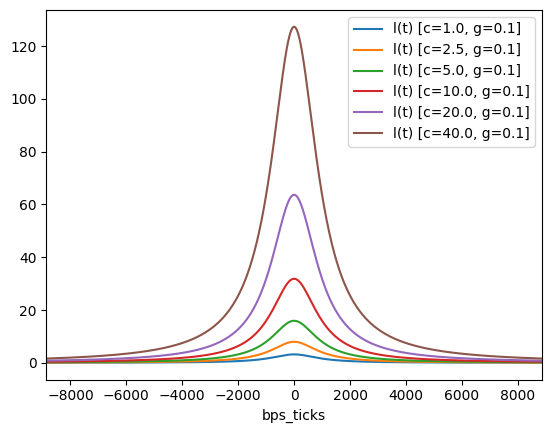

In [19]:
df.plot(x='bps_ticks', y=[f'l(t) [c={c}, g={GAMMA}]' for c in cs], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [20]:
# examine slippage for base Cauchy case of C, GAMMA
df[f'dt/dy [c={C}, g={GAMMA}]'] = clp.slip_y(log_ticks)
df[f'dt/dx [c={C}, g={GAMMA}]'] = clp.slip_x(log_ticks)

<Axes: xlabel='bps_ticks'>

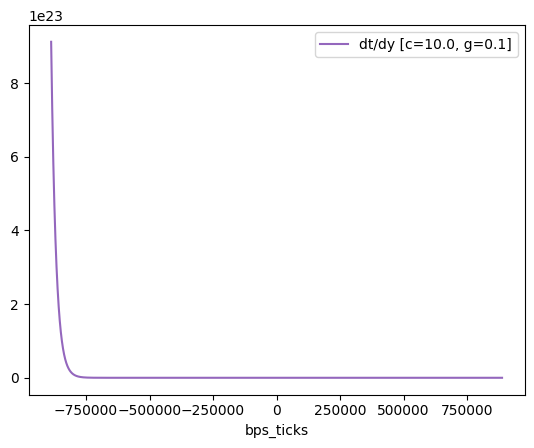

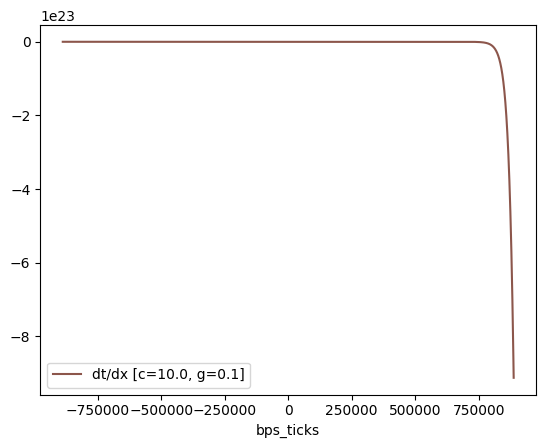

In [21]:
# plot y and x slippage across all ticks
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4')
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5')

In [22]:
df[f'dt/dy [c={C}, g={GAMMA}]']

0         9.123342e+23
1         9.118576e+23
2         9.113813e+23
3         9.109052e+23
4         9.104293e+23
              ...     
177450    2.686949e-15
177451    2.685667e-15
177452    2.684385e-15
177453    2.683104e-15
177454    2.681823e-15
Name: dt/dy [c=10.0, g=0.1], Length: 177455, dtype: float64

In [23]:
# if pool is 10 bps away from p=1, and swap in 10% of liquidity in y
# should expect tick to increase by ~6% to 10.63 bps away
(0.1 * clp.c) * clp.slip_y(from_bps_tick(10))

0.06280672598454913

<Axes: xlabel='bps_ticks'>

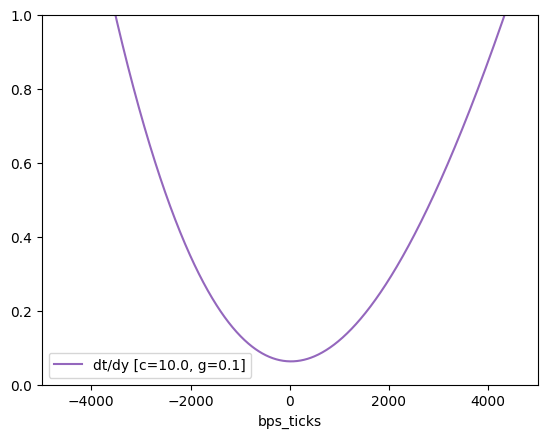

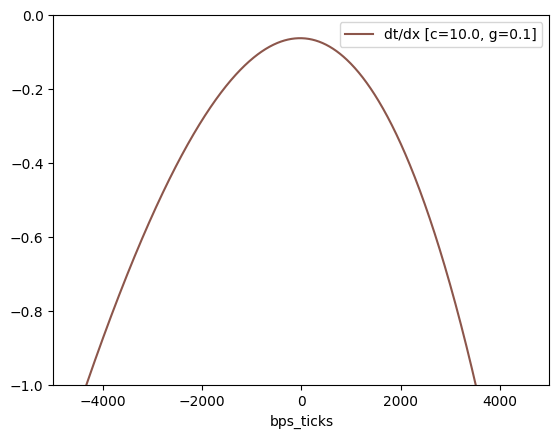

In [24]:
# plot y and x slippage across near tick=0 to +/-50%
# slippage accelerates as move toward price extremes, but bottoms as approach tick=0
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

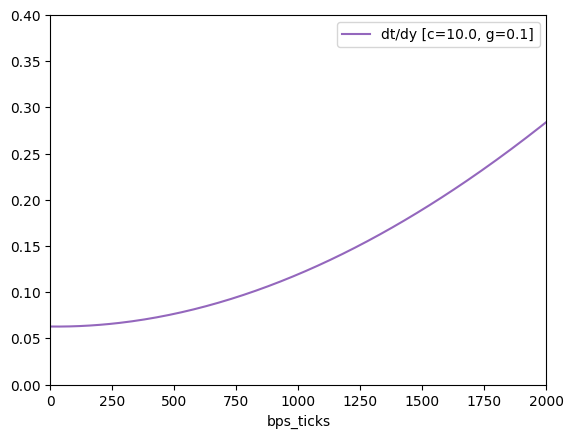

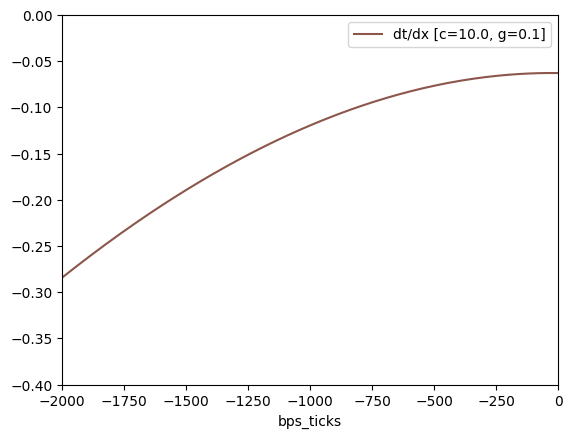

In [25]:
# plot y and x slippage from tick=0 to +/-20%
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-2000, 0), ylim=(-0.4, 0))

In [26]:
# look at slippage curves for different gamma values
for g in gammas:
    df[f'dt/dy [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).slip_y(log_ticks)
    df[f'dt/dx [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).slip_x(log_ticks)

In [27]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dy [c=10.0, g=0.025]","dt/dx [c=10.0, g=0.025]","dt/dy [c=10.0, g=0.05]","dt/dx [c=10.0, g=0.05]","dt/dy [c=10.0, g=0.2]","dt/dx [c=10.0, g=0.2]","dt/dy [c=10.0, g=0.5]","dt/dx [c=10.0, g=0.5]","dt/dy [c=10.0, g=1.0]","dt/dx [c=10.0, g=1.0]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.649332e+24,-1.072523e-14,1.824667e+24,-5.362616e-15,4.561688e+23,-1.340660e-15,1.824724e+23,-5.362785e-16,9.124489e+22,-2.681648e-16
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.647426e+24,-1.073035e-14,1.823713e+24,-5.365177e-15,4.559305e+23,-1.341301e-15,1.823771e+23,-5.365346e-16,9.119723e+22,-2.682929e-16
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.645521e+24,-1.073548e-14,1.822761e+24,-5.367739e-15,4.556924e+23,-1.341941e-15,1.822818e+23,-5.367908e-16,9.114959e+22,-2.684210e-16
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.643616e+24,-1.074060e-14,1.821809e+24,-5.370303e-15,4.554543e+23,-1.342582e-15,1.821866e+23,-5.370472e-16,9.110197e+22,-2.685492e-16
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.641713e+24,-1.074573e-14,1.820857e+24,-5.372867e-15,4.552164e+23,-1.343223e-15,1.820914e+23,-5.373036e-16,9.105438e+22,-2.686774e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.074778e-14,-3.640952e+24,5.373893e-15,-1.820476e+24,1.343480e-15,-4.551213e+23,5.374062e-16,-1.820534e+23,2.687287e-16,-9.103536e+22
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.074265e-14,-3.642855e+24,5.371328e-15,-1.821428e+24,1.342839e-15,-4.553591e+23,5.371497e-16,-1.821485e+23,2.686005e-16,-9.108293e+22
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.073753e-14,-3.644759e+24,5.368765e-15,-1.822380e+24,1.342198e-15,-4.555971e+23,5.368933e-16,-1.822437e+23,2.684722e-16,-9.113054e+22
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.073240e-14,-3.646664e+24,5.366202e-15,-1.823332e+24,1.341557e-15,-4.558353e+23,5.366371e-16,-1.823390e+23,2.683441e-16,-9.117817e+22


<Axes: xlabel='bps_ticks'>

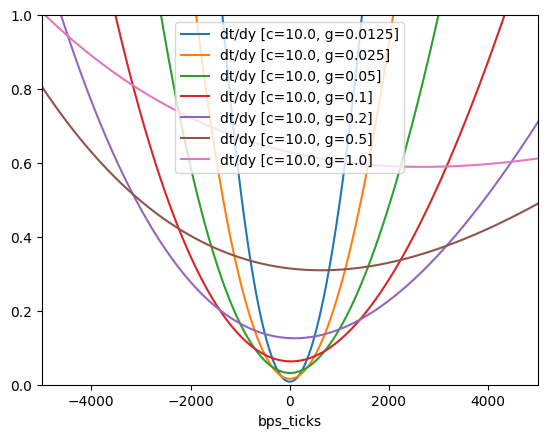

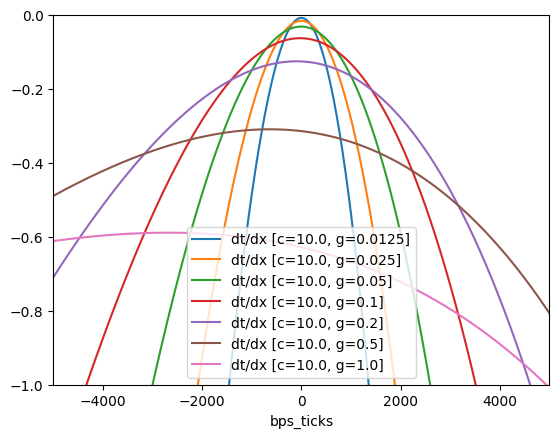

In [28]:
# plot y and x slippage across near tick=0 to +/-50% for multiple gammas
# slippage accelerates quicker at smaller tick deltas for lower gamma values (higher leverage near tick=0) 
df.plot(x='bps_ticks', y=[f'dt/dy [c={C}, g={g}]' for g in gammas], xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=[f'dt/dx [c={C}, g={g}]' for g in gammas], xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

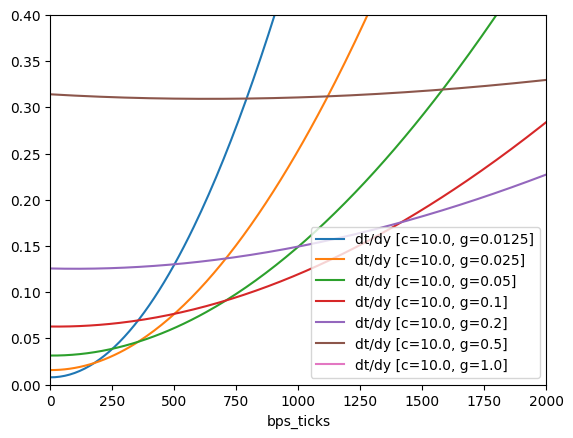

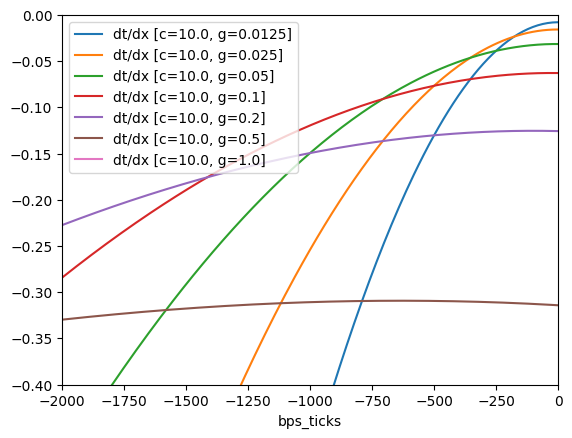

In [29]:
# plot y and x slippage from tick=0 to +/-20% for multiple gammas
# lower gamma appropriate for pairs where expect most price action within smaller tick range around tick=0
df.plot(x='bps_ticks', y=[f'dt/dy [c={C}, g={g}]' for g in gammas], xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=[f'dt/dx [c={C}, g={g}]' for g in gammas], xlim=(-2000, 0), ylim=(-0.4, 0))

In [30]:
# look at slippage curves for different global liquidity constant values
for c in cs:
    df[f'dt/dy [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).slip_y(log_ticks)
    df[f'dt/dx [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).slip_x(log_ticks)

In [31]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dy [c=1.0, g=0.1]","dt/dx [c=1.0, g=0.1]","dt/dy [c=2.5, g=0.1]","dt/dx [c=2.5, g=0.1]","dt/dy [c=5.0, g=0.1]","dt/dx [c=5.0, g=0.1]","dt/dy [c=20.0, g=0.1]","dt/dx [c=20.0, g=0.1]","dt/dy [c=40.0, g=0.1]","dt/dx [c=40.0, g=0.1]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.123342e+24,-2.681311e-14,3.649337e+24,-1.072524e-14,1.824668e+24,-5.362621e-15,4.561671e+23,-1.340655e-15,2.280835e+23,-6.703277e-16
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.118576e+24,-2.682591e-14,3.647430e+24,-1.073036e-14,1.823715e+24,-5.365182e-15,4.559288e+23,-1.341296e-15,2.279644e+23,-6.706478e-16
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.113813e+24,-2.683872e-14,3.645525e+24,-1.073549e-14,1.822763e+24,-5.367745e-15,4.556906e+23,-1.341936e-15,2.278453e+23,-6.709681e-16
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.109052e+24,-2.685154e-14,3.643621e+24,-1.074062e-14,1.821810e+24,-5.370308e-15,4.554526e+23,-1.342577e-15,2.277263e+23,-6.712885e-16
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.104293e+24,-2.686436e-14,3.641717e+24,-1.074574e-14,1.820859e+24,-5.372872e-15,4.552147e+23,-1.343218e-15,2.276073e+23,-6.716091e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.686949e-14,-9.102391e+24,1.074780e-14,-3.640956e+24,5.373899e-15,-1.820478e+24,1.343475e-15,-4.551195e+23,6.717373e-16,-2.275598e+23
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.685667e-14,-9.107148e+24,1.074267e-14,-3.642859e+24,5.371334e-15,-1.821430e+24,1.342833e-15,-4.553574e+23,6.714167e-16,-2.276787e+23
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.684385e-14,-9.111908e+24,1.073754e-14,-3.644763e+24,5.368770e-15,-1.822382e+24,1.342192e-15,-4.555954e+23,6.710962e-16,-2.277977e+23
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.683104e-14,-9.116670e+24,1.073241e-14,-3.646668e+24,5.366207e-15,-1.823334e+24,1.341552e-15,-4.558335e+23,6.707759e-16,-2.279168e+23


<Axes: xlabel='bps_ticks'>

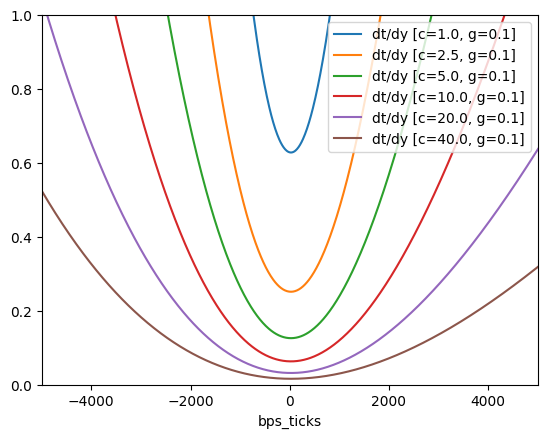

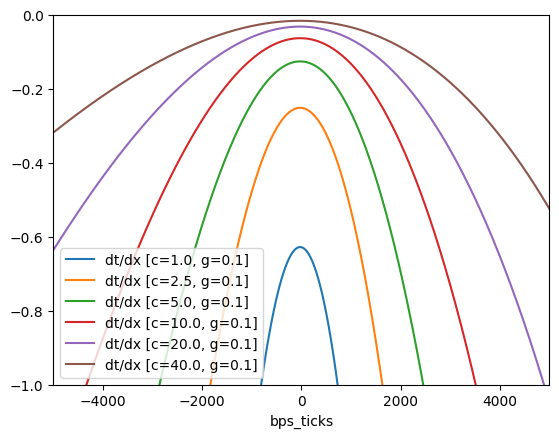

In [32]:
# plot y and x slippage across near tick=0 to +/-50% for multiple liquidity constants
# higher liquidity constant also means less slippage acceleration once moves away from tick=0 range
df.plot(x='bps_ticks', y=[f'dt/dy [c={c}, g={GAMMA}]' for c in cs], xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=[f'dt/dx [c={c}, g={GAMMA}]' for c in cs], xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

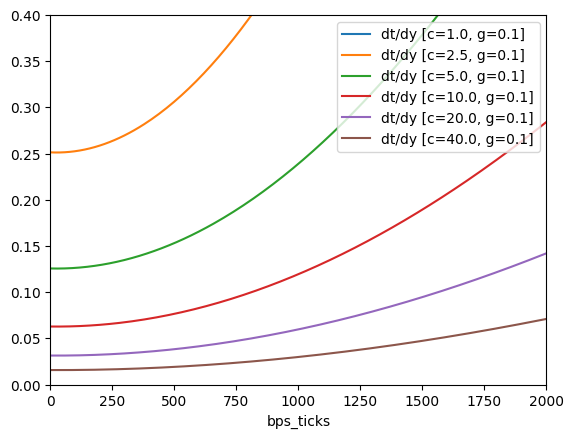

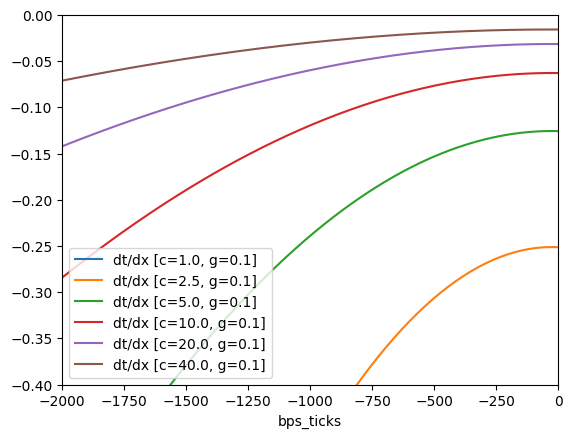

In [33]:
# plot y and x slippage from tick=0 to +/-20% for multiple liquidity constants
# more global liquidity seems to also translate to wider bottoming out of slippage near tick=0
df.plot(x='bps_ticks', y=[f'dt/dy [c={c}, g={GAMMA}]' for c in cs], xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=[f'dt/dx [c={c}, g={GAMMA}]' for c in cs], xlim=(-2000, 0), ylim=(-0.4, 0))

In [34]:
# @dev executing this cell takes a while given the numerical integration on each tick range step

# as gamma decreases, higher leverage around tick=0 implies larger amount of capital needed to move pool price
#  ... gamma=0.0125: to move tick 0.1% higher from 0, need to swap in to pool ~1.27% of y reserves for cost leverage of 12.7x
#  ... gamma=0.1: to move tick 0.1% higher from 0, need to swap in to pool ~0.15% of y reserves for cost leverage of 1.5x

# with tradeoff that as pool price moves further away from tick=0, lower gamma results in faster drop off in
# cost of capital to move pool per unit of tick change
#  ... gamma=0.0125: to move tick 0.1% higher from tick=500 to tick=510, cost leverage of 0.75x
#  ... gamma=0.1: to move tick 0.1% higher from tick=500 to tick=510, cost leverage of 1.3x

width = 10  # bps (0.1%)
top = 600  # bps (6%)
tick_ranges = [(width * i, width * (i+1)) for i in range(top // width)]

for i, f in tick_ranges:
    for g in gammas:
        reserves_x = CauchyLiquidityProfile(c=C, gamma=g).reserves_x(from_bps_tick(i), from_bps_tick(MAX_TICK))
        reserves_y = CauchyLiquidityProfile(c=C, gamma=g).reserves_y(from_bps_tick(i), from_bps_tick(MAX_TICK))

        # x values
        cost_x = CauchyLiquidityProfile(c=C, gamma=g).cost_x(from_bps_tick(i), from_bps_tick(f))
        cost_x_rel = cost_x / reserves_x
        cost_x_lev = (cost_x_rel * 1e4) / width

        # y values
        cost_y = CauchyLiquidityProfile(c=C, gamma=g).cost_y(from_bps_tick(i), from_bps_tick(f))
        cost_y_rel = cost_y / reserves_y
        cost_y_lev = (cost_y_rel * 1e4) / width

        print(f"(i, f): ({i}, {f}); g: {g}; rx: {reserves_x}; xout per rx (bps): {cost_x_rel * 1e4}; xout per rx per dt (factor): {cost_x_lev}") 
        print(f"(i, f): ({i}, {f}); g: {g}; ry: {reserves_y}; yin per ry (bps): {cost_y_rel * 1e4}; yin per ry per dt (factor): {cost_y_lev}")
        print()

(i, f): (0, 10); g: 0.0125; rx: 2.4452623810158904; xout per rx (bps): -519.4343269957511; xout per rx per dt (factor): -51.94343269957511
(i, f): (0, 10); g: 0.0125; ry: 2.4452623810158904; yin per ry (bps): 519.693819803699; yin per ry per dt (factor): 51.969381980369896

(i, f): (0, 10); g: 0.025; rx: 2.404218933984677; xout per rx (bps): -264.57232950403755; xout per rx per dt (factor): -26.457232950403757
(i, f): (0, 10); g: 0.025; ry: 2.404218933984677; yin per ry (bps): 264.7046068663324; yin per ry per dt (factor): 26.470460686633242

(i, f): (0, 10); g: 0.05; rx: 2.3356413812258845; xout per rx (bps): -136.2246829437444; xout per rx per dt (factor): -13.622468294374439
(i, f): (0, 10); g: 0.05; ry: 2.3356413812258845; yin per ry (bps): 136.2928043674823; yin per ry per dt (factor): 13.629280436748228

(i, f): (0, 10); g: 0.1; rx: 2.2249797031249328; xout per rx (bps): -71.50712676692821; xout per rx per dt (factor): -7.150712676692821
(i, f): (0, 10); g: 0.1; ry: 2.22497970312

In [70]:
# to compare with curve, calculate the amount of x out required to move pool to tick t for various ticks
top = 10000 # bps
bps_ticks_in_ranges = np.array([width * i for i in range((top + width) // width)])
df_w_ranges = pd.DataFrame(data={
    'bps_ticks': bps_ticks_in_ranges,
    'log_ticks': from_bps_tick(bps_ticks_in_ranges),
    'price': np.exp(from_bps_tick(bps_ticks_in_ranges)),
    'price^{-1}': np.exp(-from_bps_tick(bps_ticks_in_ranges))
})

In [73]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1}
0,0,0.00000,1.000000,1.000000
1,10,0.00100,1.001000,0.999001
2,20,0.00200,1.002002,0.998002
3,30,0.00300,1.003004,0.997005
4,40,0.00400,1.004008,0.996008
...,...,...,...,...
996,9960,0.99595,2.707296,0.369372
997,9970,0.99695,2.710004,0.369003
998,9980,0.99795,2.712715,0.368634
999,9990,0.99895,2.715429,0.368266


In [74]:
df_w_ranges[f'xout [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.cost_x(from_bps_tick(0), from_bps_tick(t)))
df_w_ranges[f'yin [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.cost_y(from_bps_tick(0), from_bps_tick(t)))
df_w_ranges[f'rx0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
df_w_ranges[f'ry0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

In [75]:
df_w_ranges[f'xout/rx0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges[f'xout [c={clp.c}, g={clp.gamma}]'] / df_w_ranges[f'rx0 [c={clp.c}, g={clp.gamma}]']
df_w_ranges[f'|xout|/rx0 [c={clp.c}, g={clp.gamma}]'] = np.abs(df_w_ranges[f'xout [c={clp.c}, g={clp.gamma}]']) / df_w_ranges[f'rx0 [c={clp.c}, g={clp.gamma}]']
df_w_ranges[f'yin/ry0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges[f'yin [c={clp.c}, g={clp.gamma}]'] / df_w_ranges[f'ry0 [c={clp.c}, g={clp.gamma}]']

In [76]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1},"xout [c=10.0, g=0.1]","yin [c=10.0, g=0.1]","rx0 [c=10.0, g=0.1]","ry0 [c=10.0, g=0.1]","xout/rx0 [c=10.0, g=0.1]","|xout|/rx0 [c=10.0, g=0.1]","yin/ry0 [c=10.0, g=0.1]"
0,0,0.00000,1.000000,1.000000,-0.000000,0.000000,2.22498,2.22498,-0.000000,0.000000,0.000000
1,10,0.00100,1.001000,0.999001,-0.015910,0.015918,2.22498,2.22498,-0.007151,0.007151,0.007154
2,20,0.00200,1.002002,0.998002,-0.031809,0.031841,2.22498,2.22498,-0.014296,0.014296,0.014311
3,30,0.00300,1.003004,0.997005,-0.047694,0.047766,2.22498,2.22498,-0.021436,0.021436,0.021468
4,40,0.00400,1.004008,0.996008,-0.063561,0.063689,2.22498,2.22498,-0.028567,0.028567,0.028624
...,...,...,...,...,...,...,...,...,...,...,...
996,9960,0.99595,2.707296,0.369372,-2.172865,2.542641,2.22498,2.22498,-0.976577,0.976577,1.142771
997,9970,0.99695,2.710004,0.369003,-2.172961,2.542903,2.22498,2.22498,-0.976621,0.976621,1.142888
998,9980,0.99795,2.712715,0.368634,-2.173058,2.543163,2.22498,2.22498,-0.976664,0.976664,1.143005
999,9990,0.99895,2.715429,0.368266,-2.173154,2.543424,2.22498,2.22498,-0.976707,0.976707,1.143122


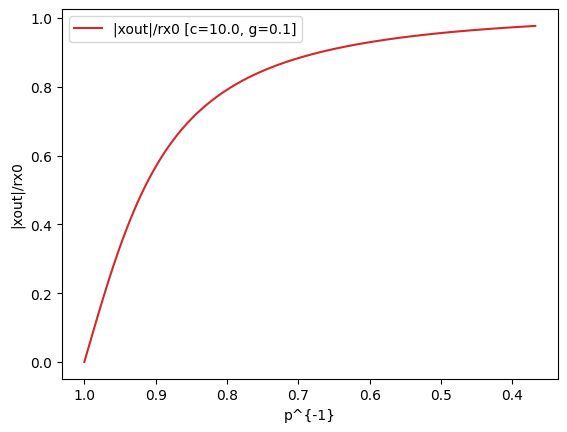

In [77]:
# plot inverse price vs x out as fraction of initial reserves
ax = df_w_ranges.plot(y=f'|xout|/rx0 [c={C}, g={GAMMA}]', x='price^{-1}', ylabel=f'|xout|/rx0', xlabel='p^{-1}', label=f'|xout|/rx0 [c={C}, g={GAMMA}]', color='C3')
ax.invert_xaxis()

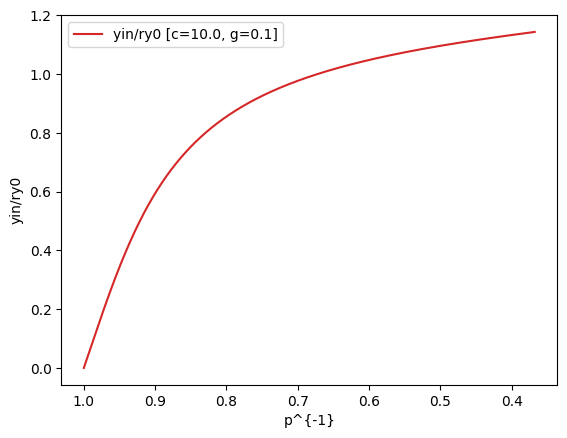

In [78]:
# plot inverse price vs y in as fraction of initial reserves
ax = df_w_ranges.plot(y=f'yin/ry0 [c={C}, g={GAMMA}]', x='price^{-1}', ylabel=f'yin/ry0', xlabel='p^{-1}', label=f'yin/ry0 [c={C}, g={GAMMA}]', color='C3')
ax.invert_xaxis()

In [79]:
# calculate relevant curve slippage quantities for different gamma values
for g in gammas:
    print(f"Calculating in/out slippage quantities for gamma: {g} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={C}, g={g}]'] = df_w_ranges[f'xout [c={C}, g={g}]'] / df_w_ranges[f'rx0 [c={C}, g={g}]']
    df_w_ranges[f'|xout|/rx0 [c={C}, g={g}]'] = np.abs(df_w_ranges[f'xout [c={C}, g={g}]']) / df_w_ranges[f'rx0 [c={C}, g={g}]']
    df_w_ranges[f'yin/ry0 [c={C}, g={g}]'] = df_w_ranges[f'yin [c={C}, g={g}]'] / df_w_ranges[f'ry0 [c={C}, g={g}]']

Calculating in/out slippage quantities for gamma: 1.0 ......

In [80]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1},"xout [c=10.0, g=0.1]","yin [c=10.0, g=0.1]","rx0 [c=10.0, g=0.1]","ry0 [c=10.0, g=0.1]","xout/rx0 [c=10.0, g=0.1]","|xout|/rx0 [c=10.0, g=0.1]",...,"xout/rx0 [c=10.0, g=0.5]","|xout|/rx0 [c=10.0, g=0.5]","yin/ry0 [c=10.0, g=0.5]","xout [c=10.0, g=1.0]","yin [c=10.0, g=1.0]","rx0 [c=10.0, g=1.0]","ry0 [c=10.0, g=1.0]","xout/rx0 [c=10.0, g=1.0]","|xout|/rx0 [c=10.0, g=1.0]","yin/ry0 [c=10.0, g=1.0]"
0,0,0.00000,1.000000,1.000000,-0.000000,0.000000,2.22498,2.22498,-0.000000,0.000000,...,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.369571,1.369571,-0.000000,0.000000,0.000000
1,10,0.00100,1.001000,0.999001,-0.015910,0.015918,2.22498,2.22498,-0.007151,0.007151,...,-0.001857,0.001857,0.001858,-0.001591,0.001592,1.369571,1.369571,-0.001162,0.001162,0.001162
2,20,0.00200,1.002002,0.998002,-0.031809,0.031841,2.22498,2.22498,-0.014296,0.014296,...,-0.003714,0.003714,0.003717,-0.003181,0.003185,1.369571,1.369571,-0.002323,0.002323,0.002325
3,30,0.00300,1.003004,0.997005,-0.047694,0.047766,2.22498,2.22498,-0.021436,0.021436,...,-0.005569,0.005569,0.005577,-0.004771,0.004778,1.369571,1.369571,-0.003483,0.003483,0.003489
4,40,0.00400,1.004008,0.996008,-0.063561,0.063689,2.22498,2.22498,-0.028567,0.028567,...,-0.007423,0.007423,0.007438,-0.006359,0.006372,1.369571,1.369571,-0.004643,0.004643,0.004653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,9960,0.99595,2.707296,0.369372,-2.172865,2.542641,2.22498,2.22498,-0.976577,0.976577,...,-0.863906,0.863906,1.241910,-1.010306,1.568792,1.369571,1.369571,-0.737681,0.737681,1.145462
997,9970,0.99695,2.710004,0.369003,-2.172961,2.542903,2.22498,2.22498,-0.976621,0.976621,...,-0.864133,0.864133,1.242525,-1.010791,1.570106,1.369571,1.369571,-0.738035,0.738035,1.146422
998,9980,0.99795,2.712715,0.368634,-2.173058,2.543163,2.22498,2.22498,-0.976664,0.976664,...,-0.864360,0.864360,1.243140,-1.011276,1.571420,1.369571,1.369571,-0.738389,0.738389,1.147381
999,9990,0.99895,2.715429,0.368266,-2.173154,2.543424,2.22498,2.22498,-0.976707,0.976707,...,-0.864586,0.864586,1.243753,-1.011760,1.572733,1.369571,1.369571,-0.738742,0.738742,1.148340


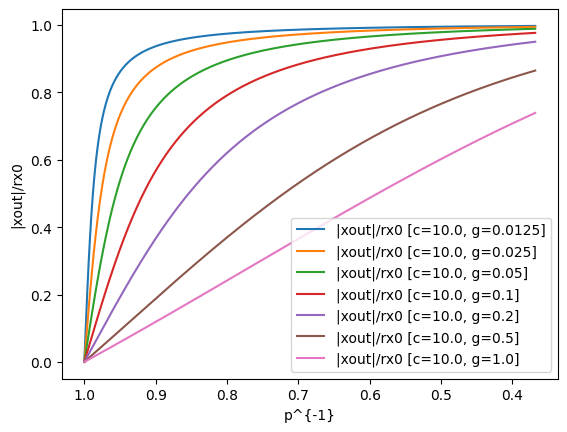

In [81]:
# plot inverse price vs x out as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas])
ax.invert_xaxis()

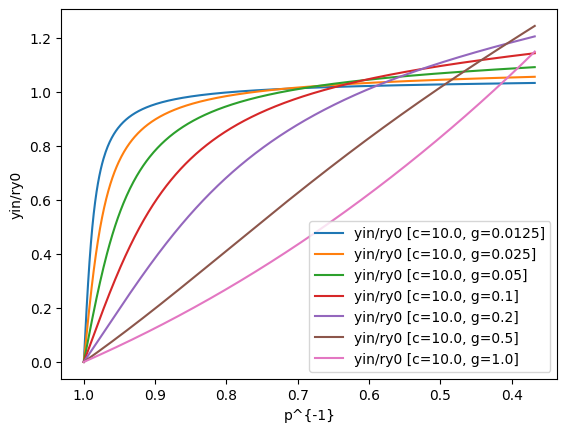

In [82]:
# plot inverse price vs y in as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={C}, g={g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={C}, g={g}]' for g in gammas])
ax.invert_xaxis()

In [83]:
# TODO: replicate reserves plot with cauchy, stableswap, and uniswap curves using lp.reserve_x, lp.reserve_y at different ticks

In [84]:
# TODO: modified cauchy liquidity profile by supplementing cauchy with base layer of full range liquidity so transitions to constant
# product in tails

In [85]:
# track progress of tick / gamma and how that relates to drop offs
df[df['bps_ticks'] > 0]['log_ticks'] / gammas[0]

88728        0.063997
88729        0.143993
88730        0.223989
88731        0.303985
88732        0.383981
             ...     
177450    7097.469132
177451    7097.549128
177452    7097.629124
177453    7097.709120
177454    7097.789116
Name: log_ticks, Length: 88727, dtype: float64

In [86]:
for g in gammas:
    df[f'log_tick / g [g={g}]'] = df['log_ticks'] / g

In [87]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dx [c=20.0, g=0.1]","dt/dy [c=40.0, g=0.1]","dt/dx [c=40.0, g=0.1]",log_tick / g [g=0.0125],log_tick / g [g=0.025],log_tick / g [g=0.05],log_tick / g [g=0.1],log_tick / g [g=0.2],log_tick / g [g=0.5],log_tick / g [g=1.0]
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.340655e-15,2.280835e+23,-6.703277e-16,-7097.821115,-3548.910557,-1774.455279,-887.227639,-443.613820,-177.445528,-88.722764
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.341296e-15,2.279644e+23,-6.706478e-16,-7097.741119,-3548.870559,-1774.435280,-887.217640,-443.608820,-177.443528,-88.721764
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.341936e-15,2.278453e+23,-6.709681e-16,-7097.661123,-3548.830561,-1774.415281,-887.207640,-443.603820,-177.441528,-88.720764
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.342577e-15,2.277263e+23,-6.712885e-16,-7097.581127,-3548.790563,-1774.395282,-887.197641,-443.598820,-177.439528,-88.719764
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.343218e-15,2.276073e+23,-6.716091e-16,-7097.501131,-3548.750565,-1774.375283,-887.187641,-443.593821,-177.437528,-88.718764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.551195e+23,6.717373e-16,-2.275598e+23,7097.469132,3548.734566,1774.367283,887.183642,443.591821,177.436728,88.718364
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.553574e+23,6.714167e-16,-2.276787e+23,7097.549128,3548.774564,1774.387282,887.193641,443.596821,177.438728,88.719364
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.555954e+23,6.710962e-16,-2.277977e+23,7097.629124,3548.814562,1774.407281,887.203641,443.601820,177.440728,88.720364
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.558335e+23,6.707759e-16,-2.279168e+23,7097.709120,3548.854560,1774.427280,887.213640,443.606820,177.442728,88.721364


<Axes: xlabel='log_ticks', ylabel='|xout|/rx0'>

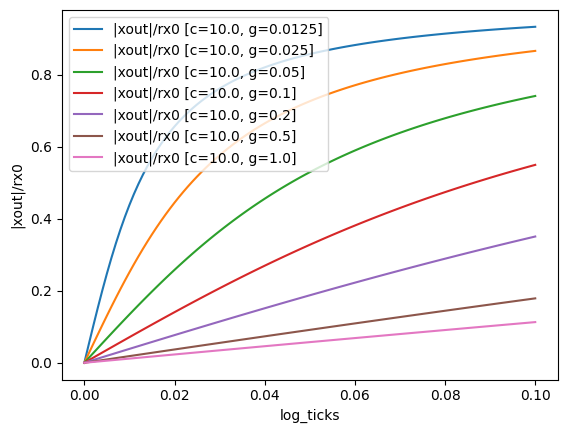

In [94]:
# at what point does x out start bending over transitioning into near infinite slippage
df_w_ranges[df_w_ranges['log_ticks'] < 0.1].plot(x='log_ticks', y=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas], xlabel='log_ticks', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas])

In [99]:
for g in gammas:
    df_w_ranges[f'log_ticks / g [g={g}]'] = df_w_ranges['log_ticks'] / g

In [100]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1},"xout [c=10.0, g=0.1]","yin [c=10.0, g=0.1]","rx0 [c=10.0, g=0.1]","ry0 [c=10.0, g=0.1]","xout/rx0 [c=10.0, g=0.1]","|xout|/rx0 [c=10.0, g=0.1]",...,"xout/rx0 [c=10.0, g=1.0]","|xout|/rx0 [c=10.0, g=1.0]","yin/ry0 [c=10.0, g=1.0]",log_ticks / g [g=0.0125],log_ticks / g [g=0.025],log_ticks / g [g=0.05],log_ticks / g [g=0.1],log_ticks / g [g=0.2],log_ticks / g [g=0.5],log_ticks / g [g=1.0]
0,0,0.00000,1.000000,1.000000,-0.000000,0.000000,2.22498,2.22498,-0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000
1,10,0.00100,1.001000,0.999001,-0.015910,0.015918,2.22498,2.22498,-0.007151,0.007151,...,-0.001162,0.001162,0.001162,0.079996,0.039998,0.019999,0.010000,0.005000,0.0020,0.00100
2,20,0.00200,1.002002,0.998002,-0.031809,0.031841,2.22498,2.22498,-0.014296,0.014296,...,-0.002323,0.002323,0.002325,0.159992,0.079996,0.039998,0.019999,0.010000,0.0040,0.00200
3,30,0.00300,1.003004,0.997005,-0.047694,0.047766,2.22498,2.22498,-0.021436,0.021436,...,-0.003483,0.003483,0.003489,0.239988,0.119994,0.059997,0.029999,0.014999,0.0060,0.00300
4,40,0.00400,1.004008,0.996008,-0.063561,0.063689,2.22498,2.22498,-0.028567,0.028567,...,-0.004643,0.004643,0.004653,0.319984,0.159992,0.079996,0.039998,0.019999,0.0080,0.00400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,9960,0.99595,2.707296,0.369372,-2.172865,2.542641,2.22498,2.22498,-0.976577,0.976577,...,-0.737681,0.737681,1.145462,79.676016,39.838008,19.919004,9.959502,4.979751,1.9919,0.99595
997,9970,0.99695,2.710004,0.369003,-2.172961,2.542903,2.22498,2.22498,-0.976621,0.976621,...,-0.738035,0.738035,1.146422,79.756012,39.878006,19.939003,9.969502,4.984751,1.9939,0.99695
998,9980,0.99795,2.712715,0.368634,-2.173058,2.543163,2.22498,2.22498,-0.976664,0.976664,...,-0.738389,0.738389,1.147381,79.836008,39.918004,19.959002,9.979501,4.989751,1.9959,0.99795
999,9990,0.99895,2.715429,0.368266,-2.173154,2.543424,2.22498,2.22498,-0.976707,0.976707,...,-0.738742,0.738742,1.148340,79.916004,39.958002,19.979001,9.989501,4.994750,1.9979,0.99895


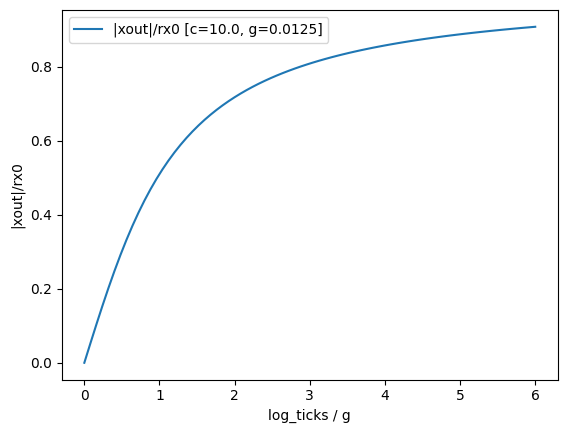

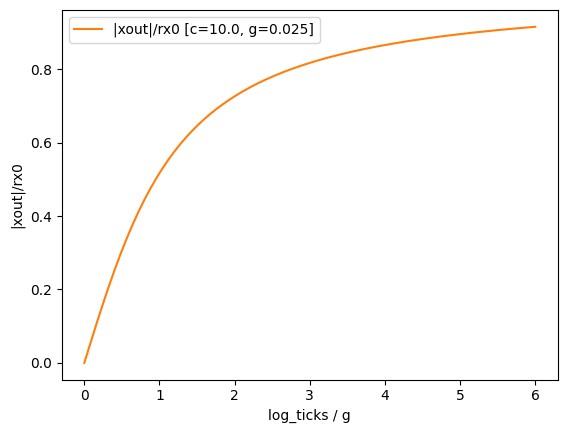

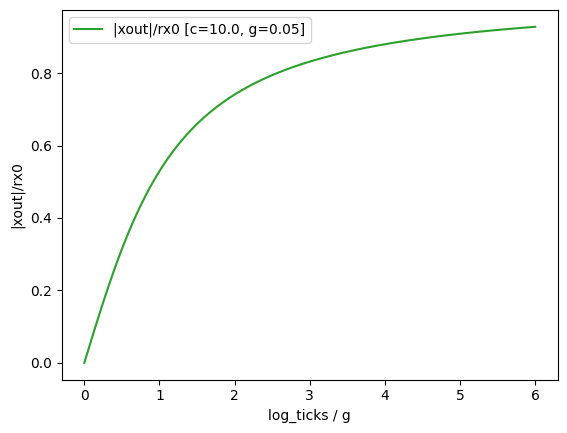

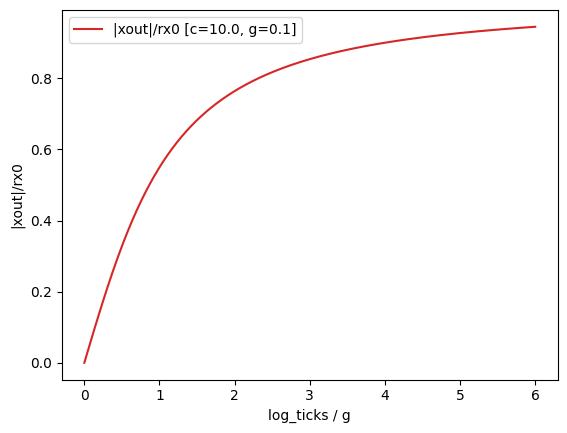

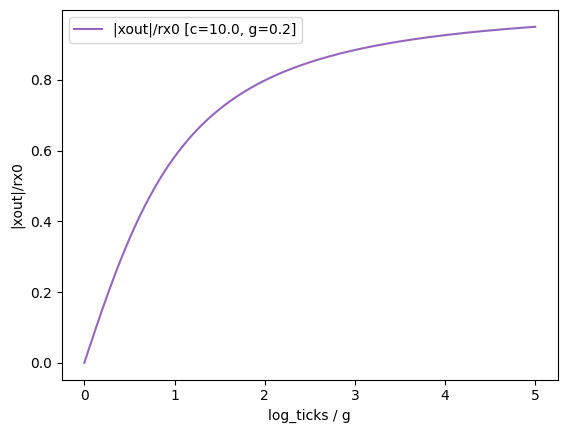

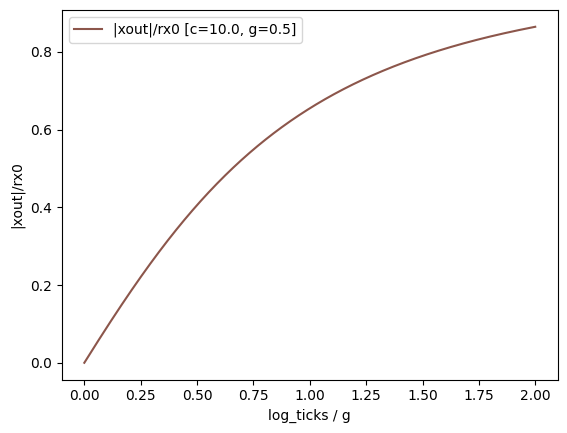

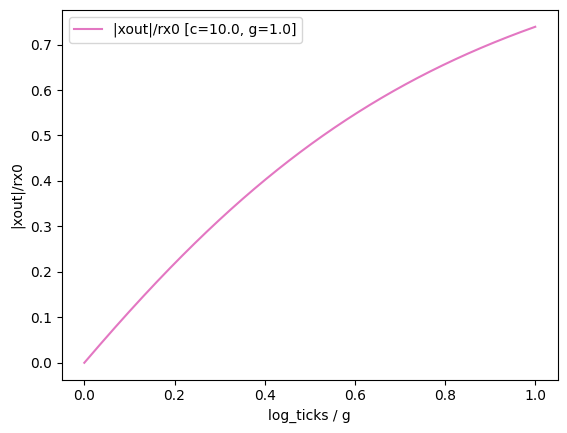

In [109]:
# plot each x out vs x axis with log ticks scaled relative to gamma g
for i, g in enumerate(gammas):
    df_w_ranges[df_w_ranges[f'log_ticks / g [g={g}]'] < 6].plot(x=f'log_ticks / g [g={g}]', y=f'|xout|/rx0 [c={C}, g={g}]', xlabel='log_ticks / g', ylabel=f'|xout|/rx0', label=f'|xout|/rx0 [c={C}, g={g}]', color=f'C{i}')

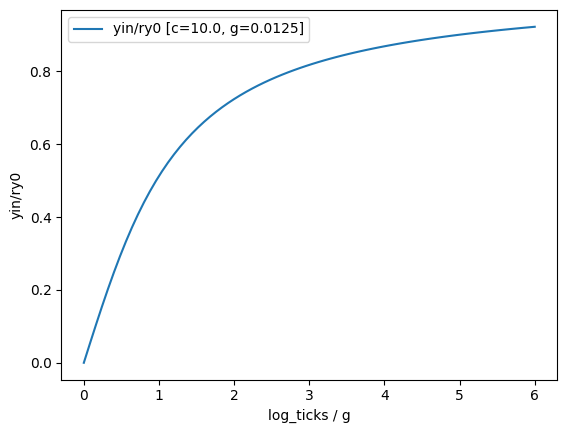

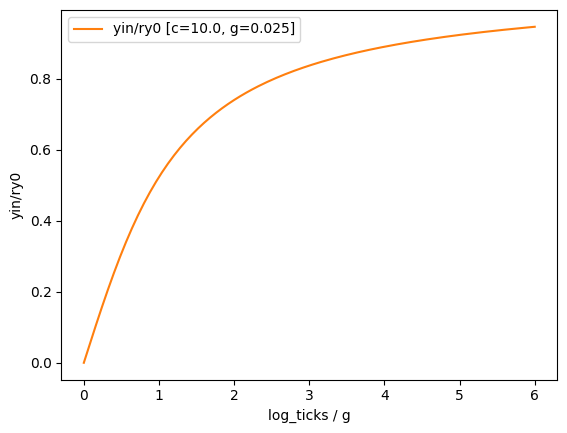

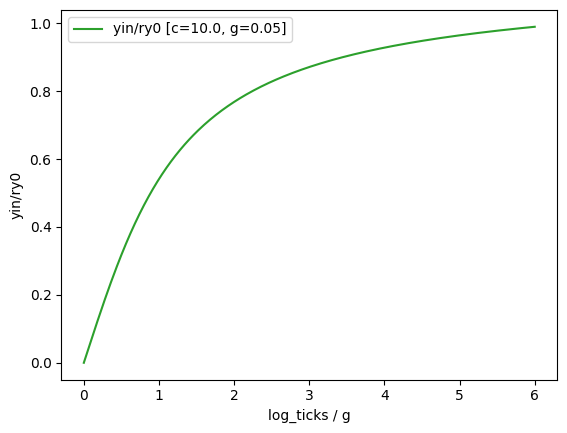

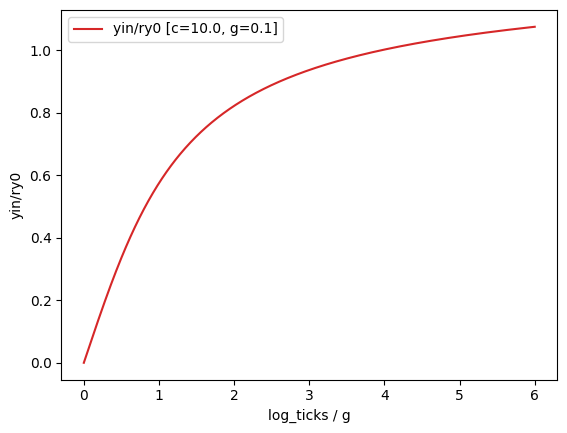

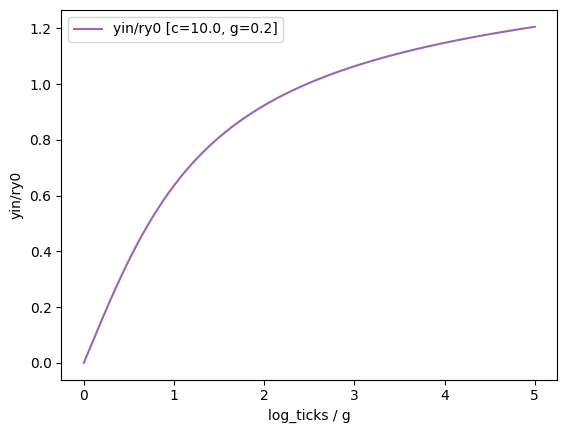

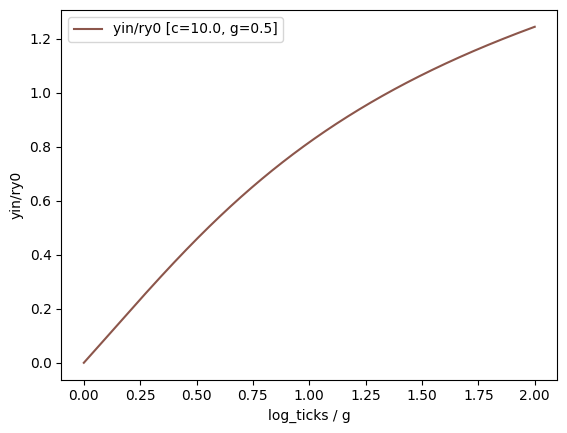

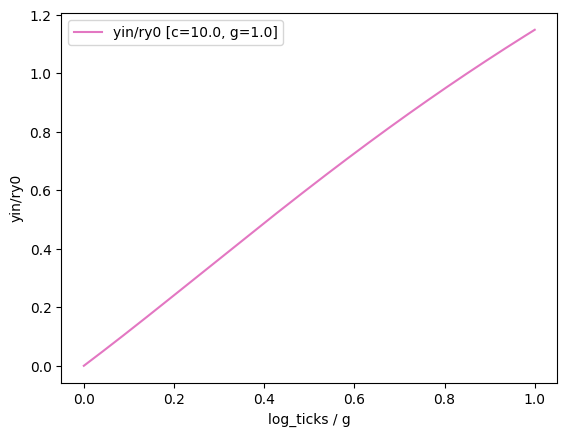

In [158]:
# plot each y in vs x axis with log ticks scaled relative to gamma g
for i, g in enumerate(gammas):
    df_w_ranges[df_w_ranges[f'log_ticks / g [g={g}]'] < 6].plot(x=f'log_ticks / g [g={g}]', y=f'yin/ry0 [c={C}, g={g}]', xlabel='log_ticks / g', ylabel=f'yin/ry0', label=f'yin/ry0 [c={C}, g={g}]', color=f'C{i}')

In [133]:
# seems like around 2 * gamma starts to break. look at slippage expressions
df_w_ranges[(df_w_ranges[f'log_ticks / g [g={gammas[0]}]'] > 1.95) & (df_w_ranges[f'log_ticks / g [g={gammas[0]}]'] < 2.05)].filter(items=[f'log_ticks / g [g={gammas[0]}]', f'|xout|/rx0 [c={C}, g={gammas[0]}]'])

,log_ticks / g [g=0.0125],"|xout|/rx0 [c=10.0, g=0.0125]"
25,1.9999,0.717335


In [139]:
df_w_ranges[(df_w_ranges[f'log_ticks / g [g={gammas[4]}]'] > 1.95) & (df_w_ranges[f'log_ticks / g [g={gammas[4]}]'] < 2.05)].filter(items=[f'log_ticks / g [g={gammas[4]}]', f'|xout|/rx0 [c={C}, g={gammas[4]}]'])

,log_ticks / g [g=0.2],"|xout|/rx0 [c=10.0, g=0.2]"
391,1.954902,0.792725
392,1.959902,0.793384
393,1.964902,0.794040
394,1.969902,0.794693
395,1.974901,0.795344
396,1.979901,0.795991
397,1.984901,0.796635
398,1.989901,0.797276
399,1.994900,0.797915
400,1.999900,0.798551
